In [86]:
import numpy as np

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator

from qiskit import *

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

ibmqfactory.load_account:WARNING:2021-09-28 03:04:58,314: Credentials are already in use. The existing account in the session will be replaced.


<div align=center class="alert alert-block alert-success">
    <h1>IQOSF Mentorship Program:</h1>
        <h1>Task 1</h1>
    <h2>Abdiel Guerrero V. </h2>
</div>

<div align=center class="alert alert-block alert-info">
    <h1>Table of Contents</h1>
</div>

| |
|:-|
|    [Problem](#Problem)|
|[Example 1](#Example_1)|
|[Defining a strategy](#Estr)|
|[1. Input Vector](#Inp_Vec)|
|[2. Convert into binary representation](#Bin_rep)|
|[3. Encoding Data](#Encod_data)|
|[3.1 Creating a qRAM](#Create_qRAM)|
|[3.2 Grover's Algorithm](#Grover)|

---

<h1><a  style="color:#A510E5;" id='Problem'>Problem</a></h1>

Design a quantum circuit that considers as input the following vector of integers numbers:

$$
\begin{bmatrix}
1 & 5 & 7 & 10
\end{bmatrix}
$$

returns a quantum state which is a superposition of indices of the target solution, <code style="background:pink;color:black">obtaining in the output the indices of the imputs where two adjacent bits will always have different values</code>. In this case the output should be:

$$
\frac{1}{\sqrt{2}} \big( |01\rangle + |11 \rangle  \big)
$$

,as the correct indices are 1 and 3.

`[0]`: 1 = 0001

`[1]`: 5 = 0101

`[2]`: 7 = 0111

`[3]`: 10 = 1010

The method to follow for this task is to start from an array of integers as input, pass them to a binary representation and you need to find those integers whose binary representation is such that two adjacent bits are different. Once you have found those integers, you must output a superposition of states where each state is a binary representation of the indices of those integers.

---

<h2><a style="color:#C868C6", id='Example_1'>Example 1</a></h2>

1. Consider the vector 
$
\begin{bmatrix}
1 & 5 & 4 & 2
\end{bmatrix}
$

2. Pass the integer values to binary numbers that is `[001, 101, 100, 010]`

3. Returns the linear combination of the indices in which the values satisfying the criteria are found.

$$
[0] \implies 001 \\ 
[1] \implies 101 \\ 
[2] \implies 100 \\ 
[3] \implies 010 
$$

4. Indices are converted to binary states:

$$
001 \implies |00\rangle \\ 
101 \implies |01\rangle \\ 
100 \implies |10\rangle \\ 
010 \implies |11\rangle \\ 
$$

5. Therefore, the answer would be the superposition of the state $|01 \rangle$ and $|11\rangle$, it means

$$
\frac{1}{\sqrt{2}}\bigg(\big| 01\big\rangle + \big|11\big \rangle \bigg)
$$

---

<h1><a style="color:#A510E5", id='Estr'>Defining a strategy</a></h1>

<h2><a style="color:#C868C6", id='Inp_Vec'>1. Input Vector</a></h2>

First of all, we need to obtain our input vector. In this case, the vector is `[1, 5, 7, 10]`

In [151]:
v = np.array([1,
              5,
              7,
             10])
print(v)

[ 1  5  7 10]


<h2><a style="color:#C868C6",  id='Bin_rep'>2. Convert into binary representation</a></h2>

Then, we need to convert the previous vector into a binary form.

In [152]:
vals_ = []
for i in v:
    vals_.append((bin(i)[2:]))
vals_

['1', '101', '111', '1010']

remember that each element in the list will be related with his index when we will construct our quantum circuit.

In [153]:
for i in vals_:
    print(f'Value: {i} , Indices: {vals_.index(i)}')

Value: 1 , Indices: 0
Value: 101 , Indices: 1
Value: 111 , Indices: 2
Value: 1010 , Indices: 3


---

<h2><a style="color:#C868C6",  id='Encod_data'>3. Encoding Data</a></h2>

Each element of our input vector will be associated with an index and a quantum state in the Quantum Circuit in the next way:

$$
\begin{aligned}
1  \implies 1    &\implies  [0] \implies |00 \rangle \\ 
5  \implies 101  &\implies  [1] \implies |01 \rangle \\
7  \implies 111  &\implies  [2] \implies |10 \rangle \\
10 \implies 1010 &\implies [3] \implies |11 \rangle \\
\end{aligned}
$$

In this case, we will need  2 qubits to encode our data directions, i.e. ($|00\rangle$, $|01\rangle$, $\cdots$); and $2^2$ qubits to express our binary values, the necessary ones to construct our next qRAM .

The premise that our quantum circuit needs is try to find those integers whose binary representation are such that, two adjacent bits, representing our binary values; be different.

$$
\begin{aligned}
1    &\implies  0001 \implies |00 \rangle \\ 
101  &\implies  0101 \implies |01 \rangle \\
111  &\implies  0111 \implies |10 \rangle \\
1010 &\implies  1010 \implies |11 \rangle \\
\end{aligned}
$$

so, we will fill our data with zeros to the left side:

In [154]:
for i in range(4):
    vals_[i] = vals_[i].zfill(4)
vals_

['0001', '0101', '0111', '1010']

Remember that we need the superposition of the states which accomplish the condition, so we need to put it into a superposition before to pass to the encoding part.

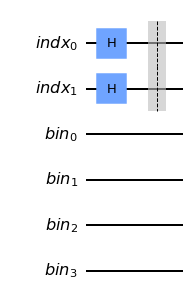

In [155]:
index_reg = QuantumRegister(2, name='indx')
bin_vals  = QuantumRegister(4, name='bin')
qc = QuantumCircuit(index_reg,bin_vals)

qc.h(index_reg)
qc.barrier(index_reg)

qc.draw('mpl')

then, we introduce our encoding part trying to obtain the output

$$
\frac{1}{2} 
\bigg( 
|00\rangle |0001\rangle +
|01\rangle |0101\rangle + 
|10\rangle |0111\rangle + 
|11\rangle |1010\rangle  \bigg)
$$

To be able to make this search trying to find the states whose binary representation accomplish the condition, <code style="background:pink;color:black">we will use a qRAM and Grover's algorithm to perform this search over a subset of our possible states</code>.

<table>
    <tr>
        <th>
            <img src="https://i.imgur.com/PgFtlgq.png" width="384px"/>
        </th>
    </tr>
    <tr>
        <th>
            Our expected qRAM 
        </th>
    </tr>
</table>

where,

<table>
    <tr>
        <th>
            <img src="https://i.imgur.com/cpIFA4N.png" width="384px"/>
        </th>
    </tr>
    <tr>
        <th>
            Equivalence
        </th>
    </tr>
</table>

<h2><a style="color:#C868C6",  id='Create_qRAM'>3.1 Creating qRAM</a></h2>

In [467]:
print(vals_)

['0001', '0101', '0111', '1010']


00
j: 0, val: 0, counter: 3
j: 1, val: 0, counter: 2
j: 2, val: 0, counter: 1
j: 3, val: 1, counter: 0
01
j: 0, val: 0, counter: 3
j: 1, val: 1, counter: 2
j: 2, val: 0, counter: 1
j: 3, val: 1, counter: 0
10
j: 0, val: 0, counter: 3
j: 1, val: 1, counter: 2
j: 2, val: 1, counter: 1
j: 3, val: 1, counter: 0
11
j: 0, val: 1, counter: 3
j: 1, val: 0, counter: 2
j: 2, val: 1, counter: 1
j: 3, val: 0, counter: 0


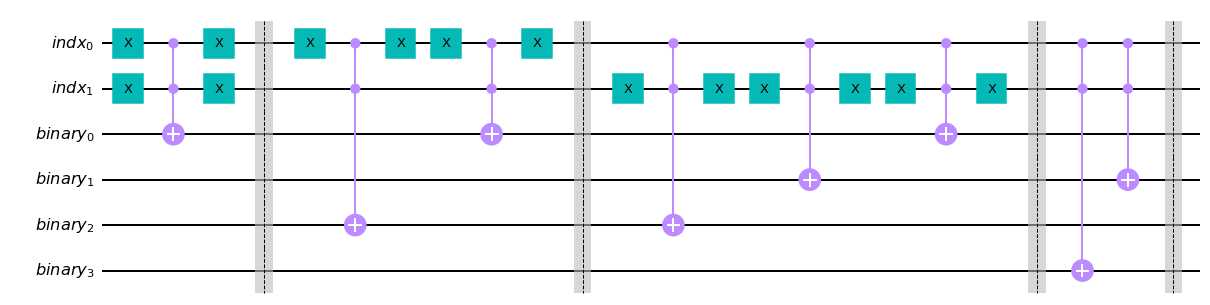

In [481]:
address_reg = QuantumRegister(np.sqrt(len(vals_)), name='indx')
binary_reg  = QuantumRegister(len(vals_), name='binary')

qc = QuantumCircuit(address_reg,binary_reg)

n = len(vals_)

for indx in range(n):
    
    # Create adrress indices
    bin_indx = bin(4 + indx)[-2:]
    print(bin_indx)
    
    count = len(vals_[indx])-1
    for j, val in enumerate(vals_[indx]):
        print(f'j: {j}, val: {val}, counter: {count}')
        
        if val == '1':
            if bin_indx[0] == '0':
                qc.x(0)
            if bin_indx[1] == '0':
                qc.x(1)
            qc.ccx(0,1, binary_reg[count])
            if bin_indx[0] == '0':
                qc.x(0)
            if bin_indx[1] == '0':
                qc.x(1)
        count = count -1
    qc.barrier()

qc.draw('mpl')    

once we check that it is the circuit that we expect, we will put all within a function that returns a gate.

In [482]:
def q_RAM(n, reg_1, reg_2):
    
    qc = QuantumCircuit(reg_1,reg_2)
    for indx in range(n):

        # Create adrress indices
        bin_indx = bin(4 + indx)[-2:]

        count = len(vals_[indx])-1
        for j, val in enumerate(vals_[indx]):        
            if val == '1':
                if bin_indx[0] == '0':
                    qc.x(0)
                if bin_indx[1] == '0':
                    qc.x(1)
                qc.ccx(0,1, reg_2[count])
                if bin_indx[0] == '0':
                    qc.x(0)
                if bin_indx[1] == '0':
                    qc.x(1)
            count = count -1 
    gate = qc.to_gate()
    gate.name = 'qRAM'
    return gate  

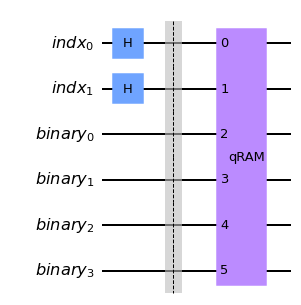

In [483]:
address_reg_ = QuantumRegister(np.sqrt(len(vals_)), name='indx')
binary_reg_  = QuantumRegister(len(vals_), name='binary')
qc_ = QuantumCircuit(address_reg,binary_reg)
n = len(vals_)


qc_.h(address_reg)
qc_.barrier()


qc_.append( q_RAM(n_, address_reg_, binary_reg_), range(6) )
qc_.draw('mpl')

<h2><a style="color:#C868C6",  id='Grover'>3.2 Grover's Algorithm</a></h2>